<a href="https://colab.research.google.com/github/saritmaitra/nlp_ner_topic_modeling/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re, plac, random, pprint, string
import en_core_web_sm
string.punctuation
limit = 0
import subprocess
import unicodedata, json, csv
import datetime, pickle, copy
import pandas as pd
import csv, json, time, sys
import warnings
#To perform LDA, we'll use gensim.
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

# Gensim
import gensim
import gensim.corpora as corpora

from pandas import DataFrame, concat
from joblib import Parallel, delayed
from spacy import displacy
from string import punctuation
from collections import Counter
from pathlib import Path
from tqdm import tqdm  # loading bar
from IPython.display import display
from tqdm import tqdm 
from spacy.lang.en import STOP_WORDS
from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from itertools import groupby 
from collections import OrderedDict
import csv, json, random
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.chunk import tree2conlltags

# Load Packages
from __future__ import unicode_literals, print_function
import sys
import plac #  wrapper over argparse
import random
from pathlib import Path
import nltk, spacy
from tqdm import tqdm # loading bar
from functools import reduce
from tqdm.notebook import tqdm
tqdm.pandas(desc="progress-bar")


from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from tqdm import tqdm, tqdm_notebook
from tqdm import tqdm_notebook as tqdm
from tqdm.auto import tqdm
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk, pos_tag_sents
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
pd.options.display.max_columns = 20
%time
def news_articles(): 
  df = pd.read_csv(
    'articles.csv', 
    usecols=['date', 'title', 'author', 'content'],
    engine='python',
    error_bad_lines=False
    )
  df.drop_duplicates('content')         # Remove duplicate from "content" columns
  df = df[~df['content'].isnull()]      # Remove rows with empty cotent
  df.dropna(inplace=True) 
  return (df)

df = news_articles()
df.head(3) # sanity check

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


,title,author,date,content
0,House Republicans Fret About Winning Their Hea...,Carl Hulse,12/31/2016,WASHINGTON — Congressional Republicans have...
1,Rift Between Officers and Residents as Killing...,Benjamin Mueller and Al Baker,6/19/2017,"After the bullet shells get counted, the blood..."
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",Margalit Fox,1/6/2017,"When Walt Disney’s “Bambi” opened in 1942, cri..."


In [4]:
%time
def initial_process(df):
  data = df.copy()
  data = data[~data['content'].isnull()]  # Remove rows with empty cotent

  # Select contents of length between 140 and 2000 characters.
  data = data[(data.content.map(len) > 140) & (data.content.map(len) <= 2000)]
  data.reset_index(inplace=True, drop=True)

  # collecting 10000 random sample for computational ease
  data = data.sample(10000, random_state=2021)
  data.reset_index(inplace=True, drop=True)

  # aligning the columns in order of requirement
  data = data[['date', 'title', 'author', 'content']]
  # renaming date -> date_of_news
  data.rename(columns = {'date': 'date_of_news'}, inplace = True)
  return (data)

data = initial_process(df)
data.tail(3) # sanity check


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


,date_of_news,title,author,content
9997,6/23/2016,The Milo Show: ’Social Justice Is Turning the ...,Tom Ciccotta,On this week’s episode of The Milo Yiannopoulo...
9998,3/8/2017,The Browns reportedly have a ’dream scenario’ ...,Scott Davis,’ ’ ’ With a the Cleveland Browns could ...
9999,4/5/2017,Roger Stone: Jared Kushner Leaking Anti-Bannon...,Breitbart News,Republican strategist Roger Stone claims that ...


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


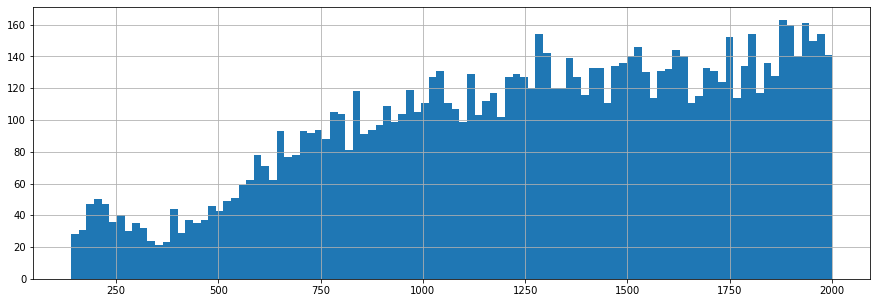

In [5]:
%time
# Let's now check the disctribution of the contents' lengths.
data.content.map(len).hist(figsize=(15, 5), bins=100)
plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


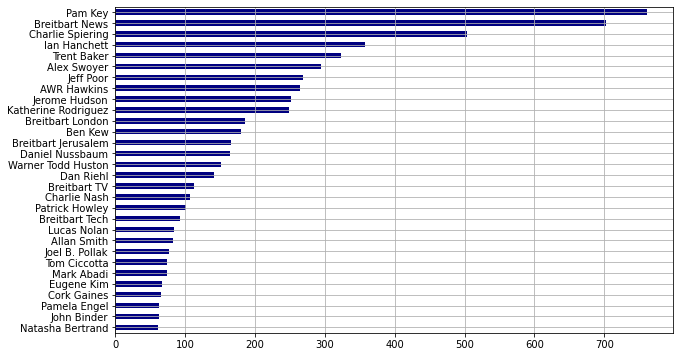

In [6]:
%time
topics = data['author'].value_counts().to_frame()[:30]
topics.sort_values(by='author', ascending=True).plot(
    kind = 'barh', colormap='jet', legend=False, figsize=(10, 6));
plt.grid(True)

In [7]:
%time
def preProcess(text):
  #  Remove non-ASCII characters
  text = (unicodedata.normalize('NFKD', text)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')\
    .lower())                   # lower case lowers the sparsity of the data
  
  # remove numbers
  text = re.sub(r'\d+', '', str(text))

  # removing salutaions (if any)
  text = re.sub("Mr\.",'Mr',  str(text))
  text = re.sub("Mrs\.",'Mrs',str(text))

  text = re.sub(r"what's", "what is ", text)
  text = re.sub(r'won\'t', 'will not', text)
  text = text.replace('(ap)', '')
  text = re.sub(r"\'s", " is ", text)
  text = re.sub(r'(\w+)\'s', '\g<1> is', text)
  text = re.sub(r'(\w+)\'ve', '\g<1> have', text)
  text = re.sub(r"can't", "cannot ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm", "i am ", text)
  text = re.sub(r"\'re", " are ", text)
  text = re.sub(r"\'d", " would ", text)
  text = re.sub(r"\'ll", " will ", text)

   
  # substitute multiple whitespace with single whitespace
  # Also, removes leading and trailing whitespaces
  text = re.sub(r'\W+', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  
  # removing any reference to outside text
  text = re.sub(r"\\", "", text)
  text = re.sub(r"\'", "", text)    
  text = re.sub(r"\"", "", text)

  text = text.strip()
  return text

# preprocessing texts
data['processedContent'] = data['content'].apply(preProcess)
data.head(3)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump o...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...
2,7/5/2016,Donald Trump Reacts to James Comey: ’No Charge...,Alex Swoyer,Presumptive GOP nominee Donald Trump reacted t...,presumptive gop nominee donald trump reacted t...


## function to remove the rare words

In [8]:
%time
num_of_rare_words = 25
RARE_WORDS = set([w for (w, wc) in Counter().most_common()[:-num_of_rare_words-1:-1]])
def remove_rare_words(text):
  return " ".join([word for word in str(text).split() if word not in RARE_WORDS])

data["processedContent"] = data["processedContent"].apply(lambda text: remove_rare_words(text))
data.head(3)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump o...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...
2,7/5/2016,Donald Trump Reacts to James Comey: ’No Charge...,Alex Swoyer,Presumptive GOP nominee Donald Trump reacted t...,presumptive gop nominee donald trump reacted t...


## function to remove the frequent words

In [9]:
%time
FREQ_WORDS = set([w for (w, wc) in Counter().most_common(25)])
def remove_freq_words(text):
    return " ".join([word for word in str(text).split() if word not in FREQ_WORDS])

data["processedContent"] = data["processedContent"].apply(lambda text: remove_freq_words(text))
data.head(3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump o...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...
2,7/5/2016,Donald Trump Reacts to James Comey: ’No Charge...,Alex Swoyer,Presumptive GOP nominee Donald Trump reacted t...,presumptive gop nominee donald trump reacted t...


## function to remove the stopwords

In [10]:
%time
with open('stopwords.json') as json_file:
    addStopwords = json.load(json_file)
    print(addStopwords); print(len(addStopwords['en']))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs
{'en': ['a', "a's", 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon", "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'co

In [12]:
%time
add_stopwords = set(addStopwords['en'])
stop_words = set(stopwords.words('english'))

# add words that aren't in the NLTK stopwords list
STOPWORDS = stop_words.union(add_stopwords)
STOPWORDS = list(STOPWORDS)
print(STOPWORDS); print()
print(len(STOPWORDS))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["processedContent"] = data["processedContent"].apply(lambda text: remove_stopwords(text))
data.head(2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
['below', 'okay', 'many', 'who', 'much', 'else', 'nine', 'look', 'rather', "they've", 'hardly', 'whatever', 'become', 'thank', 'cause', 'p', 'should', 'mightn', "shouldn't", 'beyond', 'the', 'wherein', 'gives', 'specifying', 'nobody', 'seems', 'two', 'co', 'right', 'appropriate', 'why', 'inner', 'via', 'itself', 'same', 'afterwards', 'provides', 'unlikely', 'by', 'let', 'whenever', 'your', 'didn', 'concerning', 'shouldn', 'five', 're', "they'd", 's', 'toward', 'accordingly', 'go', "ain't", 'knows', 'uucp', 'given', 'even', 'containing', 'u', "who's", 'described', 'someone', 'third', 'thoroughly', 'possible', 'themselves', 'as', 'haven', "it'd", 'believe', 'seeming', "wouldn't", 'might', "they'll", 'did', 'with', 'cannot', 'ok', "there's", 'yet', 'get', 'once', 'almost', 'certainly', 'specified', 'if', 'plus', 'associated', 'z', 'during', 'furthermore', 'six', 'ignored', 'says', 'besides', 'done', 'e', "i'm", 'meanwhile', '

,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump t...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...


In [13]:
%time
wnl = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([wnl.lemmatize(word) for word in text.split()])

data["processedContent"] = data["processedContent"].apply(lambda text: lemmatize_words(text))
data.head(2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump t...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...


## function to remove the punctuation

In [14]:
%time
PUNCT_REMOVE = string.punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', PUNCT_REMOVE))

data["processedContent"] = data["processedContent"].apply(lambda text: remove_punctuation(text))
data.head(3)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


,date_of_news,title,author,content,processedContent
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,’ ’ ’ Republican presidential nominee Donal...,republican presidential nominee donald trump t...
1,7/27/2016,"DNC: Bernie Supporters Not Falling in Line, Vo...",Dustin Stockton,"PHILADELPHIA, Pennsylvania — Green presiden...",philadelphia pennsylvania green presidential c...
2,7/5/2016,Donald Trump Reacts to James Comey: ’No Charge...,Alex Swoyer,Presumptive GOP nominee Donald Trump reacted t...,presumptive gop nominee donald trump reacted j...


In [18]:
%time
# tokenizer to 'processedContent' column through all rows and store in 'tokens' column.
data['tokens'] = data['processedContent'].apply(word_tokenize) 

#  POS tagging of the sentence and ne_chunk() to recognize each named entity in sentences
data['ner'] = data['processedContent']\
.apply(lambda x: nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(x)),binary=True))
data.tail(3)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


,date_of_news,title,author,content,processedContent,tokens,ner
9997,6/23/2016,The Milo Show: ’Social Justice Is Turning the ...,Tom Ciccotta,On this week’s episode of The Milo Yiannopoulo...,week episode milo yiannopoulos show milo discu...,"[week, episode, milo, yiannopoulos, show, milo...","[(week, NN), (episode, NN), (milo, NN), (yiann..."
9998,3/8/2017,The Browns reportedly have a ’dream scenario’ ...,Scott Davis,’ ’ ’ With a the Cleveland Browns could ...,cleveland brown major step forward figure inte...,"[cleveland, brown, major, step, forward, figur...","[(cleveland, NN), (brown, IN), (major, JJ), (s..."
9999,4/5/2017,Roger Stone: Jared Kushner Leaking Anti-Bannon...,Breitbart News,Republican strategist Roger Stone claims that ...,republican strategist roger stone claim presid...,"[republican, strategist, roger, stone, claim, ...","[(republican, JJ), (strategist, NN), (roger, N..."


## CSV to json

In [19]:
xDf = data[['date_of_news', 'title', 'author', 'ner']].copy()
xDf.head(1)

,date_of_news,title,author,ner
0,10/28/2016,TRUMP: ’We should just cancel the election and...,Brett LoGiurato,"[(republican, JJ), (presidential, JJ), (nomine..."


In [20]:
%time
xDf.to_csv('newDf.csv')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [21]:
%time
def csv_to_json(in_file_csv, out_file_json):
    json_array = []

    # read csv file
    with open(in_file_csv, "r", encoding="utf-8") as csv_file:
        # load csv file data using csv library's dictionary reader
        csv_reader = csv.DictReader(csv_file)

        # convert each csv row into python dict
        for row in csv_reader:
            # add the abobe python dict to json array
            json_array.append(row)

    # convert python jsonArray to JSON String and write to file
    with open(out_file_json, "w") as json_file:
        json_string = json.dumps(json_array, indent=4)
        json_file.write(json_string)


in_file_csv = r"newDf.csv"
out_file_json = r"newDf.json"

csv_to_json(in_file_csv, out_file_json)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [22]:
print(data.ner[0])

(S
  republican/JJ
  presidential/JJ
  nominee/NN
  donald/NN
  trump/NN
  thursday/NN
  hillary/JJ
  clinton/NN
  policy/NN
  bad/JJ
  election/NN
  canceled/VBD
  declared/JJ
  winner/NN
  difference/NN
  thinking/VBG
  cancel/JJ
  election/NN
  give/VB
  trump/NN
  mogul/NN
  campaigning/VBG
  toledo/JJ
  ohio/NN
  policy/NN
  bad/JJ
  trump/NN
  slamming/VBG
  claiming/NN
  plan/NN
  raise/VB
  tax/NN
  small/JJ
  business/NN
  trump/JJ
  comment/NN
  amid/IN
  day/NN
  campaigning/VBG
  critical/JJ
  battleground/NN
  state/NN
  ohio/JJ
  lead/JJ
  recent/JJ
  poll/NN
  average/JJ
  percentage/NN
  point/NN
  realclearpolitics/NNS
  trump/VBP
  trail/JJ
  clinton/NN
  average/JJ
  national/JJ
  survey/NN
  trump/NN
  recent/JJ
  week/NN
  medium/RB
  political/JJ
  elite/NN
  working/VBG
  foil/JJ
  presidential/JJ
  bid/NN
  set/VBN
  wrap/NN
  swing/VBG
  buckeye/NN
  state/NN
  wednesday/JJ
  night/NN
  rally/NN
  geneva/VBP
  clinton/NN
  appeared/VBN
  earlier/RBR
  thursday/

## Create a dictionary representation of the documents.

In [23]:
%time
yDf = data[['date_of_news', 'title', 'author', 'tokens']].copy()

bigram = gensim.models.Phrases(yDf['tokens'], min_count=5, threshold=100)
bigramModel = gensim.models.phrases.Phraser(bigram)

yDf['bigramTokens'] = yDf['tokens'].progress_map(lambda tokens: bigramModel[tokens])

# Creating Dictionary
id2word = corpora.Dictionary(yDf['bigramTokens'])

# Creating Corpus
texts = yDf['bigramTokens'].tolist()
dictionary = Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


progress-bar:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

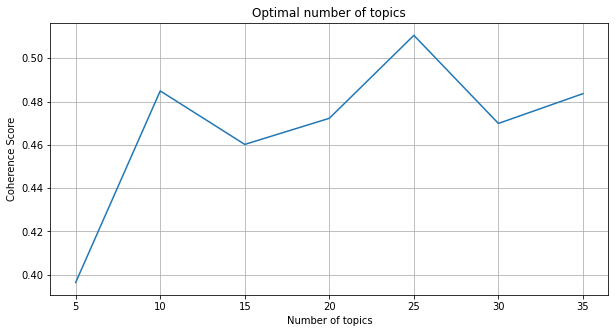

In [25]:
%time

# Define LDA model in function that takes the number of topics as a parameter.
def LDAmodel(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(
        corpus=tqdm_notebook(corpus, leave=False),
        id2word=id2word,
        alpha='auto', eta='auto',
        num_topics=num_topics, # the number of topics is equal to num_topics
        random_state=2021,
        eval_every=1,
        chunksize=2000,
        passes=passes,
        per_word_topics=True
        )
    
def coherence_computation(model):
    coherence = CoherenceModel(
        model = model, 
        texts = texts,
        dictionary = id2word, coherence='c_v'
        )
    return coherence.get_coherence()

def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=10)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    DATA = DataFrame(topics)
    DATA.index = ['topic_{0}'.format(i) for i in range(model.num_topics)]
    DATA.columns = ['keyword_{0}'.format(i) for i in range(1, 10+1)]
    return DATA

def explore_models(DATA, range = range(5, 25)):
    id2word = corpora.Dictionary(DATA['bigramTokens'])
    texts = DATA['bigramTokens'].tolist()
    corpus = [id2word.doc2bow(text) for text in texts]

    coherence_values = []
    model_list = []
    
    for num_topics in tqdm_notebook(range, leave=False):
        lda = LDAmodel(num_topics, passes=5)
        model_list.append(lda)
        coherence = coherence_computation(lda)
        coherence_values.append(coherence)
      
    fig = plt.figure(figsize=(10,5))
    plt.title('Optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.plot(range, coherence_values)
    
    return coherence_values, model_list

coherence_values, model_list = explore_models(yDf, range = range(5, 40, 5))

In [26]:
%time
# Print the coherence scores
limit=40; start=5; step=6;
x = range(start, limit, step)

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Num Topics = 5  has Coherence Value of 0.3964
Num Topics = 11  has Coherence Value of 0.4849
Num Topics = 17  has Coherence Value of 0.4602
Num Topics = 23  has Coherence Value of 0.4723
Num Topics = 29  has Coherence Value of 0.5106
Num Topics = 35  has Coherence Value of 0.4699


In [27]:
%time
pd.options.display.max_columns = 20
bestModel = LDAmodel(num_topics=10, passes=5)
print(display_topics(model = bestModel))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

         keyword_1  keyword_2 keyword_3    keyword_4     keyword_5  \
topic_0     people      black     woman         star          show   
topic_1     attack     people     state       muslim         group   
topic_2    clinton    hillary     trump        state    republican   
topic_3     police    officer  reported          man          told   
topic_4     israel   official      year         iran        border   
topic_5        gun  breitbart      news  awr_hawkins          game   
topic_6       year    student   million   university         state   
topic_7      trump     donald  campaign   republican  presidential   
topic_8      trump  president    people       donald          news   
topic_9  breitbart       news   company         year       twitter   

                keyword_6            keyword_7  keyword_8 keyword_9  \
topic_0              year                 dont       film      life   
topic_1           islamic            terrorist    migrant   country   
topic_2         

u_mass and c_v topic coherences capture the optimal number of topics by giving the interpretability of these topics a number called coherence score.

In [28]:
%time
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=bestModel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nc_v Coherence Score: ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=bestModel, texts=texts, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nUMass Coherence Score: ', coherence_lda)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs

c_v Coherence Score:  0.48490647961729216

UMass Coherence Score:  -2.314024733900072


In [29]:
bestModel.print_topics() # Print the Keyword in the 5 topics

[(0,
  '0.010*"people" + 0.007*"black" + 0.006*"woman" + 0.006*"star" + 0.005*"show" + 0.005*"year" + 0.005*"dont" + 0.004*"film" + 0.004*"life" + 0.004*"time"'),
 (1,
  '0.010*"attack" + 0.007*"people" + 0.006*"state" + 0.006*"muslim" + 0.006*"group" + 0.005*"islamic" + 0.005*"terrorist" + 0.005*"migrant" + 0.005*"country" + 0.004*"isi"'),
 (2,
  '0.037*"clinton" + 0.017*"hillary" + 0.014*"trump" + 0.010*"state" + 0.010*"republican" + 0.009*"president" + 0.009*"democratic" + 0.008*"percent" + 0.007*"vote" + 0.006*"election"'),
 (3,
  '0.021*"police" + 0.008*"officer" + 0.007*"reported" + 0.007*"man" + 0.005*"told" + 0.005*"breitbart" + 0.005*"time" + 0.005*"report" + 0.004*"suspect" + 0.004*"shooting"'),
 (4,
  '0.006*"israel" + 0.006*"official" + 0.005*"year" + 0.004*"iran" + 0.004*"border" + 0.004*"time" + 0.004*"car" + 0.004*"report" + 0.004*"wall" + 0.004*"president"'),
 (5,
  '0.017*"gun" + 0.008*"breitbart" + 0.007*"news" + 0.006*"awr_hawkins" + 0.006*"game" + 0.005*"awrhawkins_

In [30]:
bestModel[corpus[0]]

([(2, 0.36212605), (7, 0.5883803), (8, 0.042348787)],
 [(0, [7, 2, 8]),
  (1, [7, 2, 8]),
  (2, [2, 7, 8]),
  (3, [7, 2, 8]),
  (4, [2, 7]),
  (5, [7, 2]),
  (6, [7]),
  (7, [7, 2, 8]),
  (8, [7, 2]),
  (9, [7, 2, 8]),
  (10, [7, 2]),
  (11, [7, 2, 8]),
  (12, [2, 7]),
  (13, [7, 2, 8]),
  (14, [7, 2, 8]),
  (15, [7, 2, 8]),
  (16, [7, 2, 8]),
  (17, [2, 7, 8]),
  (18, [7, 2, 8]),
  (19, [7, 2, 8]),
  (20, [7, 2, 8]),
  (21, [7, 2, 8]),
  (22, [7]),
  (23, [7, 2]),
  (24, [7, 2, 8]),
  (25, [2, 7]),
  (26, [7, 2]),
  (27, [2, 7, 8]),
  (28, [2, 7, 8]),
  (29, [7, 8, 2]),
  (30, [7]),
  (31, [7, 2, 8]),
  (32, [7, 2, 8]),
  (33, [7, 2, 8]),
  (34, [2, 8, 7]),
  (35, [7, 2]),
  (36, [2, 7]),
  (37, [2, 7, 8]),
  (38, [7, 2, 8]),
  (39, [7, 2, 8]),
  (40, [2, 7]),
  (41, [7, 2]),
  (42, [2, 7, 8]),
  (43, [2, 7]),
  (44, [7, 2]),
  (45, [7]),
  (46, [7, 2, 8]),
  (47, [7, 2]),
  (48, [7, 2, 8]),
  (49, [7]),
  (50, [7, 2, 8]),
  (51, [2, 7]),
  (52, [2, 7]),
  (53, [7, 2]),
  (54, [2, 7, 

In [31]:
%matplotlib inline
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [32]:
%time
vis = gensimvis.prepare(topic_model=bestModel, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
